<a href="https://colab.research.google.com/github/jvataidee/DataAnalysis/blob/master/Analise_Financeira_Mercado_Gado_de_Corte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**by: [João Ataíde](https://www.joaoataide.com)**
# Análise Mercado Financeira de Gado de Corte


---

Que a indústria agrícola do país está em alta não é novidade, mas muito disse se dá pela análise de tendência e ciclos de produção, analises que ajudam ao produtor tomar a decisão e seguir crescendo durante os tempos.
No entanto, as análises dessas produções não são simples, em especial quando se trata de uma indústria a céu aberto, submetida a diversos tipos de variáveis, em especial a pecuária de corte, a qual possui característica plurianual, possuindo respostas mais lentas referente ao mercado, iremos ver aqui.

## Importanto bibliotecas básicas

In [1]:
#importar bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from statsmodels.tsa.seasonal import seasonal_decompose

# configurar a visualização
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Obtenção dos dados

In [2]:
!pip install investpy -q

     |████████████████████████████████| 4.4 MB 8.0 MB/s 
     |████████████████████████████████| 241 kB 68.7 MB/s 
     |████████████████████████████████| 6.3 MB 58.4 MB/s 
     |████████████████████████████████| 510 kB 77.8 MB/s 


In [3]:
!pip install yfinance -q

In [4]:
#importar bibliotecas financeiras
import investpy
import yfinance as yf
from pandas_datareader import data as wb

### Dados de Commodities

Para fazer as análises do mercado de pecuária, diversas commodities são variáveis para o trabalho, sendo elas as seguintes:



*   `Live Cattle` - preço do Boi Gordo
*   `Feeder Cattle` - preço do Boi em engorda
*   `US Soybeans` - preço da soja
*   `US Corn` - preço do milho
*   `Dollar` - preço do Dollar/Real

Para importar esses dados usarei a biblioteca investpy, que possui um API com comandos para diversos dados financeiros. Para isso, precisaremos estipular uma janela de programação no qual precisa ser maior que 6 anos, devido ao ciclo da pecuária de corte.



In [5]:
#Lista de commodities
commodities = ["Live Cattle", "Feeder Cattle"]

#Data de inicio e fim de análise
inicio = "01/01/2004"
fim = "31/12/2021"

In [6]:
#Função para importar dados das commodities
def commodities_df(commodities, inicio,fim):
  precos = pd.DataFrame()
  for i in commodities:
    df = investpy.commodities.get_commodity_historical_data(commodity=i, from_date=inicio, to_date=fim).Close
    df.rename(i, inplace=True)
    df.columns = [i]
    precos = pd.concat([precos,df], axis=1)
    precos.index.name="Date"
  return precos


#Data Frame de commodites
df = commodities_df(commodities,inicio,fim)

#Importar dollar dos anos de 2004 e 2020
doll = yf.Ticker("USDBRL=x")
dollar = pd.DataFrame(doll.history(start = "2004-01-01", end ="2020-12-31" ).Close)
dollar.columns = ["Dollar"]
dollar.index.name="Date"

#merge dado
dados =pd.merge(df, dollar, how='inner', right_index=True, left_index=True)

#Agrupar a média por trimestre
dados = dados.reset_index()
dados_trimestre = dados.groupby(pd.Grouper(key='Date', freq='Q')).median()
dados_trimestre = dados_trimestre.reset_index()
dados_trimestre.tail()

,Date,Live Cattle,Feeder Cattle,Dollar
63,2019-12-31,119.4500,145.150,4.108500
64,2020-03-31,120.1000,135.900,4.346767
65,2020-06-30,94.2875,126.315,5.334800
66,2020-09-30,104.2500,141.560,5.363700
67,2020-12-31,108.8750,138.380,5.390000


In [7]:
dados_trimestre.shape

(68, 4)

### Dados do SIDRA

Outros dados importante é referente aos números de abates dos animais por classe no intervalo de tempo, sendo usado então validar os ciclos e as sazonalidades das culturas. Para isso, precisaremos baixar todas as classes os dados referentes ao intervalo e cabeças abatidas de cada classe:


*   `Bois` - Animal macho
*   `Vacas` - Animal fêmea
*   `Novilhas` - Animal fêmea mais nova 
*   `Novilhos` - Animal macho mais novo
*   `Totais` -  Soma de todas as classes



In [8]:
#link do banco de dados sidra
consulta = 'https://apisidra.ibge.gov.br/values/t/1092/n1/all/v/all/p/all/c12716/all/c18/55,56,992,111734,111735/c12529/all/d/v1000151%202,v1000284%202,v1000285%202'
ufs = [5] #numero de consultas

#Baixar dados do sidra
df2 = pd.DataFrame()
for uf in ufs:
    url = consulta.format(uf)
    dados_json = requests.get(url).json()
    dados_pandas = pd.DataFrame(dados_json)
    df2 = pd.concat([dados_pandas,df2])

In [9]:
#Renomear colunas
sidra = df2.copy() 
colunas = list(df2.iloc[0,:])
sidra.columns = colunas

#Filtrar dados
sidra = sidra.iloc[1:,:]
sidra = sidra[sidra["Variável"]=="Animais abatidos"]
sidra = sidra[sidra["Tipo de inspeção"]=="Total"]
sidra = sidra[sidra["Unidade de Medida"]=="Cabeças"]
sidra = sidra[sidra["Referência temporal"]=="Total do trimestre"]

#Escolher colunas necessárias para a análise
sidra = sidra.reset_index()
sidra = sidra.iloc[:, [5, 11, 15]]

#Dropar coluna de valor X
sidra = sidra.drop(sidra[sidra["Valor"] == 'X'].index)

#tranformar valor em float
sidra["Valor"] = sidra["Valor"].astype(float)

#Encontrar datas
times = sidra.Trimestre.str.split(expand=True)
times[2] = pd.to_datetime(times[2])
sidra3 = sidra.copy()
sidra3 = sidra3[times[2] >= "2004"]
sidra3 = sidra3[times[2] < "2021"]
sidra3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Valor,Trimestre,Tipo de rebanho bovino
140,2946294.0,1º trimestre 2004,Bois
141,2144997.0,1º trimestre 2004,Vacas
142,5971101.0,1º trimestre 2004,Total
143,548460.0,1º trimestre 2004,Novilhos
144,324736.0,1º trimestre 2004,Novilhas


In [10]:
#Separar dados pelo tipo de rebanho
bois = sidra3[sidra3["Tipo de rebanho bovino"] == "Bois"]
vacas = sidra3[sidra3["Tipo de rebanho bovino"] == "Vacas"]
novilhas = sidra3[sidra3["Tipo de rebanho bovino"] == "Novilhos"]
novilhos = sidra3[sidra3["Tipo de rebanho bovino"] == "Novilhas"]
total = sidra3[sidra3["Tipo de rebanho bovino"] == "Total"]

In [11]:
#Função de pré join
def pre_join(dataframe, nome):
  dataframe = dataframe.reset_index()
  dataframe = dataframe.iloc[:, [1, 2]]
  dataframe.columns = [nome, "Trimestre"]
  return dataframe

#Criar contador de trimestre
bois = pre_join(bois, "Bois")
vacas = pre_join(vacas, "Vacas")
novilhas = pre_join(novilhas, "Novilhas")
novilhos = pre_join(novilhos, "Novilhos")
total = pre_join(total, "Total")

In [12]:
#Joins de todos os datasets
df_final = dados_trimestre.copy()
df_final = df_final.join(bois)
df_final = df_final.join(vacas.Vacas)
df_final = df_final.join(novilhas.Novilhas)
df_final = df_final.join(novilhos.Novilhos)
df_final = df_final.join(total.Total)

#indexar por data
df_final=df_final.set_index("Date")
df_final.tail()

,Live Cattle,Feeder Cattle,Dollar,Bois,Trimestre,Vacas,Novilhas,Novilhos,Total
Date,,,,,,,,,
2019-12-31,119.4500,145.150,4.108500,4768561.0,4º trimestre 2019,2086396.0,446799.0,779151.0,8080907.0
2020-03-31,120.1000,135.900,4.346767,3881075.0,1º trimestre 2020,2244800.0,324062.0,885949.0,7335886.0
2020-06-30,94.2875,126.315,5.334800,4126964.0,2º trimestre 2020,2061751.0,343375.0,870454.0,7402544.0
2020-09-30,104.2500,141.560,5.363700,4735421.0,3º trimestre 2020,1872475.0,390506.0,773276.0,7771678.0
2020-12-31,108.8750,138.380,5.390000,4707178.0,4º trimestre 2020,1580888.0,467577.0,607839.0,7363482.0


In [13]:
#Criar coluna de média todos os trimestres 
df_final["Média Bois"] = df_final["Bois"].mean()
df_final["Média Vacas"] = df_final["Vacas"].mean()
df_final["Média Novilhas"] = df_final["Novilhas"].mean()
df_final["Média Novilhos"] = df_final["Novilhos"].mean()
df_final["Média Total"] = df_final["Total"].mean()

## Sazonalidade

A sazonalidade são eventos que costumam ocorrer em determinado momento do ano, assim como toda e qualquer cultura a pecuária de corte não difere, entretanto, tal se diferencia devido ao seu comportamento plurianual, modificando então suas cultura a decorrer da passagem de alguns anos, que geralmente são de 5 há 6 anos.

In [14]:
#Agrupar por trimestre
trimestre = df_final.Trimestre.str.split(expand=True)
trimestre = df_final.join(trimestre)
trimestre = trimestre.groupby([0,2]).sum()
trimestre= trimestre.reset_index()
trimestre.head()

,0,2,Live Cattle,Feeder Cattle,Dollar,Bois,Vacas,Novilhas,Novilhos,Total,Média Bois,Média Vacas,Média Novilhas,Média Novilhos,Média Total
0,1º,2004,79.0000,0.0,2.90000,2946294.0,2144997.0,548460.0,324736.0,5971101.0,4.013695e+06,2.445326e+06,511338.176471,599621.985294,7.572645e+06
1,1º,2005,0.0000,0.0,0.00000,2918582.0,2541242.0,569125.0,410909.0,6446415.0,4.013695e+06,2.445326e+06,511338.176471,599621.985294,7.572645e+06
2,1º,2006,81.2375,0.0,2.16745,3135987.0,2902011.0,602218.0,434476.0,7081252.0,4.013695e+06,2.445326e+06,511338.176471,599621.985294,7.572645e+06
3,1º,2007,93.9000,0.0,2.10150,3733561.0,3081031.0,633825.0,502208.0,7957028.0,4.013695e+06,2.445326e+06,511338.176471,599621.985294,7.572645e+06
4,1º,2008,91.1750,0.0,1.74150,3419655.0,2837361.0,522262.0,467264.0,7249416.0,4.013695e+06,2.445326e+06,511338.176471,599621.985294,7.572645e+06


In [15]:
#Dataset por ano
df_2014 = trimestre[trimestre[2]== "2014"]
df_2015 = trimestre[trimestre[2]== "2015"]
df_2016 = trimestre[trimestre[2]== "2016"]
df_2017 = trimestre[trimestre[2]== "2017"]
df_2018 = trimestre[trimestre[2]== "2018"]
df_2019 = trimestre[trimestre[2]== "2019"]
df_2020 = trimestre[trimestre[2]== "2020"]

#criar dataset abate de vacas por ano
df_vacas_ano = pd.DataFrame()
df_vacas_ano["2014"]= list(df_2014.Vacas)
df_vacas_ano["2015"] = list(df_2015.Vacas)
df_vacas_ano["2016"]= list(df_2016.Vacas)
df_vacas_ano["2017"]= list(df_2017.Vacas)
df_vacas_ano["2018"]= list(df_2018.Vacas)
df_vacas_ano["2019"]= list(df_2019.Vacas)
df_vacas_ano["2020"]= list(df_2020.Vacas)
df_vacas_ano

,2014,2015,2016,2017,2018,2019,2020
0,3067441.0,2669421.0,2355450.0,2573509.0,2788623.0,2699548.0,2244800.0
1,2899909.0,2470490.0,2389478.0,2450331.0,2573407.0,2513823.0,2061751.0
2,2561439.0,2164544.0,2100239.0,2396049.0,2400531.0,2297485.0,1872475.0
3,2501305.0,2026969.0,2073648.0,2324777.0,2317097.0,2086396.0,1580888.0


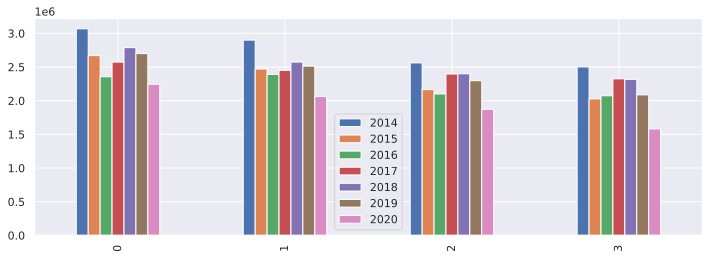

In [16]:
df_vacas_ano.plot(kind="bar", figsize = (12,4));

Eu agrupei o número de abates das fêmeas por ano e trimestre, assim foi possível identificar que no primeiro trimestre é sempre onde tem maior número de abate de fêmeas. Isso mostra a importância da questão da oferta de fêmeas no período de abate, pois quando a oferta está muito alta ela tende a preencher a escala do frigorífico e pressionar os preços da @ de macho.

**Mas por que isso é mais forte no primeiro trimestre?** isso é devido ao processo de classificação do produtor quanto as fêmeas que não irão emprenhar novamente no outro ano, assim decorre o descarte maior dessas primeiro e no segundo semestre. Outra questão é a redução que ocorre no terceiro trimestre, sendo devido a entressafra, decorrente da não existência de bois de pasto e o momento com menor oferta de fêmeas.

### Sazonalidade do Boi Gordo

In [17]:
#Pré-processando dados
dados2 = df.copy()
boi_gordo = pd.DataFrame(dados2["Live Cattle"].fillna(dados2["Live Cattle"].median()))
boi_gordo = boi_gordo.reset_index()
boi_gordo_mes = boi_gordo.groupby(pd.Grouper(key='Date',freq='M')).mean()
boi_gordo_ano = boi_gordo.groupby(pd.Grouper(key='Date',freq='Y')).mean()
boi_gordo2 = boi_gordo_mes[boi_gordo_mes.index > '2014-01-01']
boi_gordo3 = boi_gordo_mes[boi_gordo_mes.index > '2017-01-01']

In [18]:
#Calcular decomposição da série
boi_gordo_seasonal = seasonal_decompose(boi_gordo_mes)
boi_gordo2_seasonal = seasonal_decompose(boi_gordo2)
boi_gordo3_seasonal = seasonal_decompose(boi_gordo3)

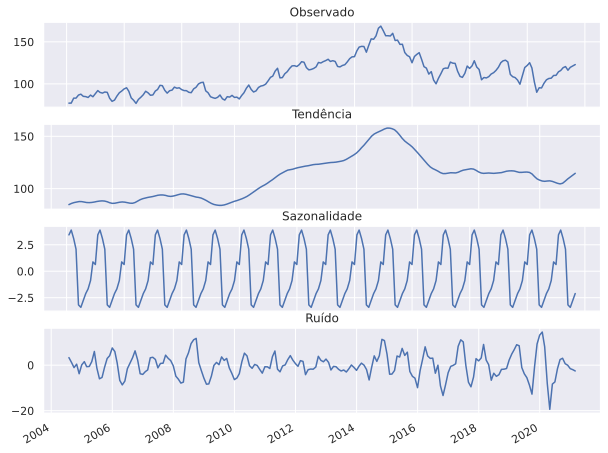

In [19]:
# Plotar decomposição e série do boi gordo
fig, ax = plt.subplots(4,figsize = (10,8))
ax[0].plot(boi_gordo_seasonal.observed)
ax[1].plot(boi_gordo_seasonal.trend)
ax[2].plot(boi_gordo_seasonal.seasonal)
ax[3].plot(boi_gordo_seasonal.resid)

ax[0].set_title('Observado')
ax[1].set_title('Tendência')
ax[2].set_title('Sazonalidade')
ax[3].set_title('Ruído')
fig.autofmt_xdate()
plt.show()

Olhando o gráfico acima podemos ver a decomposição da série temporal do preço do boi gordo no intervalo de 2004 a 2019, indicando quais as tendência e sazonalidade do preço do boi gordo.

In [20]:
#escolhendo 1 ano para sazonalidade de 1997 a 2020
boi_plot = pd.DataFrame(boi_gordo_seasonal.seasonal)
boi_plot = boi_plot.reset_index()
boi_plot = boi_plot[boi_plot["Date"] >= "2020-01-01"]
boi_plot = boi_plot[boi_plot["Date"] <= "2020-12-31"]
boi_plot["Média"] = boi_plot["Live Cattle"].mean()

#escolhendo 1 ano para sazonalidade de 2014 a 2020
boi_plot2 = pd.DataFrame(boi_gordo2_seasonal.seasonal)
boi_plot2 = boi_plot2.reset_index()
boi_plot2 = boi_plot2[boi_plot2["Date"] >= "2020-01-01"]
boi_plot2 = boi_plot2[boi_plot2["Date"] <= "2020-12-31"]

#escolhendo 1 ano para sazonalidade de 2017 a 2020
boi_plot3 = pd.DataFrame(boi_gordo3_seasonal.seasonal)
boi_plot3 = boi_plot3.reset_index()
boi_plot3 = boi_plot3[boi_plot3["Date"] >= "2020-01-01"]
boi_plot3 = boi_plot3[boi_plot3["Date"] <= "2020-12-31"]


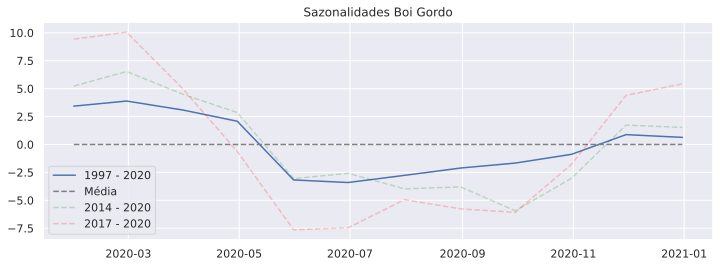

In [21]:
#plotar sazonalidade de 1 ano
fig, ax = plt.subplots(figsize = (12,4))

ax.plot(boi_plot["Date"], boi_plot["Live Cattle"],label='1997 - 2020')
ax.plot(boi_plot["Date"], boi_plot["Média"], ls ='--', color= "Grey",label='Média')
ax.plot(boi_plot2["Date"], boi_plot2["Live Cattle"], ls ='--', color= "Green",label='2014 - 2020', alpha = 0.2)
ax.plot(boi_plot3["Date"], boi_plot3["Live Cattle"], ls ='--', color= "Red",label='2017 - 2020', alpha = 0.2)
ax.set_title('Sazonalidades Boi Gordo')
ax.legend()
plt.show()

Dando um zoom para o intervalo de 1 ano, podemos ver que no começo do ano o preço começa maior que a média, assim, tendo uma queda brusca entre o mês de maio e junho, subindo novamente entre o mês de novembro e dezembro, onde repete.

Logicamente devido à pecuária ser uma indústria de céu aberto está sujeita a intemperes o que podem variar o preço, além de uma mudança brusca de mercado financeiro relacionado a demanda, assim tal modelo apresentado acima uma estimativa.

Agora olhe a diferença quando colocamos um intervalo menor para identificar a sazonalidade, veja que o valor de baixa estão aumentando, isso é devido ao maior número de criação por confinamento nos últimos anos, tal efeito se salienta quando incutamos ainda mais o período de análise, sendo então que a tendência está em mover os menores preços para os meses de setembro e outubro.

### Sazonalidade do Bezerro

In [22]:
#Pré-processando dados
dados2 = df.copy()
bezerro = pd.DataFrame(dados2["Feeder Cattle"].fillna(dados2["Live Cattle"].median()))
bezerro = bezerro.reset_index()
bezerro = bezerro.groupby(pd.Grouper(key='Date',freq='M')).first()

In [23]:
#Calcular decomposição da série temporal
bezerro_seasonal = seasonal_decompose(bezerro)

In [24]:
#escolhendo 1 ano
bezerro_plot = pd.DataFrame(bezerro_seasonal.seasonal)
bezerro_plot = bezerro_plot.reset_index()
bezerro_plot = bezerro_plot[bezerro_plot["Date"] >= "2020-01-01"]
bezerro_plot = bezerro_plot[bezerro_plot["Date"] <= "2020-12-31"]
bezerro_plot["Média"] = bezerro_plot["Feeder Cattle"].mean()


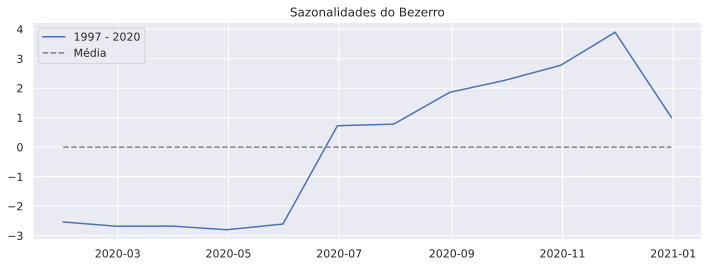

In [25]:
#plotar sazonalidade de 1 ano
fig, ax = plt.subplots(figsize = (12,4))

ax.plot(bezerro_plot["Date"], bezerro_plot["Feeder Cattle"], label='1997 - 2020')
ax.plot(bezerro_plot["Date"], bezerro_plot["Média"], ls ='--', color= "Grey",label='Média')
ax.set_title('Sazonalidades do Bezerro')
ax.legend()
plt.show()

Note que referente ao bezerro, a sazonalidade é bem diferente do anterior, sua alta de preço está por meados de outubro e novembro, com uma subida entre os meses de baixa do boi gordo, além disso, o seu maior período de baixa está no começo do ano, isso se dá pelo peso do animal, pois devido ao tempo de reprodução que ocorre no final do ano os bezerros ainda está magro.

## Ciclos

### Interferência das fêmas

In [26]:
#dataset participação das fêmeas no abate total
participacao_femeas = pd.DataFrame()
participacao_femeas["Trimestre"] = df_final['Trimestre']
participacao_femeas["Participacao"] = (df_final["Vacas"]/df_final["Total"])*100
participacao_femeas["Alto"] = participacao_femeas["Participacao"].max()
participacao_femeas["Baixa"] = participacao_femeas["Participacao"].min()
participacao_femeas["Média"] = participacao_femeas["Participacao"].mean()
participacao_femeas["R$ Bezerro"] = (df_final["Feeder Cattle"]*df_final["Dollar"])

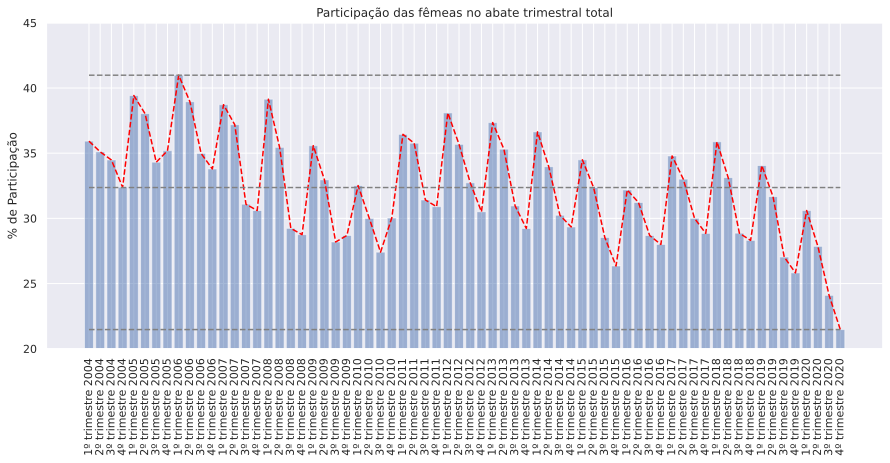

In [27]:
#Plot participação das fêmeas
fig, ax = plt.subplots( figsize = (15,6))

ax.bar(participacao_femeas["Trimestre"], participacao_femeas["Participacao"], alpha = 0.5)
ax.plot(participacao_femeas["Trimestre"], participacao_femeas["Participacao"], color = "red", ls = "--")
ax.plot(participacao_femeas["Trimestre"], participacao_femeas["Alto"], color = "grey", ls = "--")
ax.plot(participacao_femeas["Trimestre"], participacao_femeas["Baixa"], color = "grey", ls = "--")
ax.plot(participacao_femeas["Trimestre"], participacao_femeas["Média"], color = "grey", ls = "--")
ax.set_ylabel("% de Participação")
ax.set_title("Participação das fêmeas no abate trimestral total")
ax.set_ylim(20, 45)
ax.set_xticklabels(participacao_femeas["Trimestre"], rotation = 90)
plt.show()

No gráfico acima podemos ver exatamente a participação das fêmeas no abate total, onde mostra a força que estas possuem no preço do boi gordo. Note que a linha vermelha e a linha cinza é o preço máximo, projeções demonstram da ociosidade do abate do animal, onde demonstra um ciclo que dura  de 5 a 6 anos podendo varia temporalmente.-

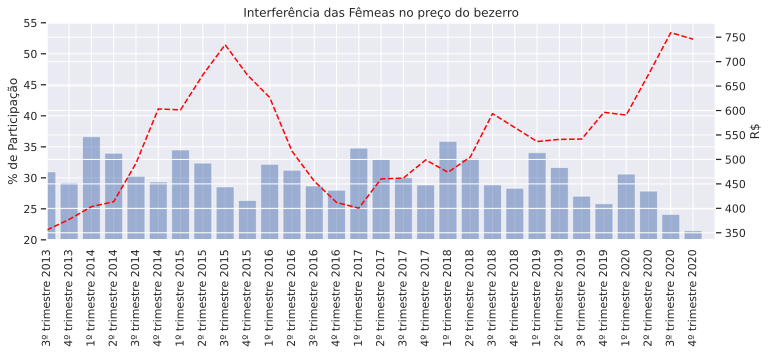

In [28]:
#Plot participação das fêmeas
fig, ax1 = plt.subplots( figsize = (12,4))

ax1.bar(participacao_femeas["Trimestre"], participacao_femeas["Participacao"], alpha = 0.5)
ax2 = ax1.twinx()
ax2.plot(participacao_femeas["Trimestre"], participacao_femeas["R$ Bezerro"], color = "red", ls = "--")

ax1.set_ylabel("% de Participação")
ax2.set_ylabel("R$")
ax1.set_title("Interferência das Fêmeas no preço do bezerro")
ax1.set_ylim(20, 55)
ax1.set_xlim(38, 68)

ax1.set_xticklabels(participacao_femeas["Trimestre"], rotation = 90)

plt.show()

Com o gráfico acima é possível identificar a interferência do abate das fêmeas no preço do bezerro, veja que assim que o número de abates de fêmeas aumenta o preço do bezerro tente a ceder, isso é devido a fatores de tomada de decisão do pecuarista, como quando o preço do bezerro baixa tendendo a abater mais fêmeas para subir as lacunas do mercado.

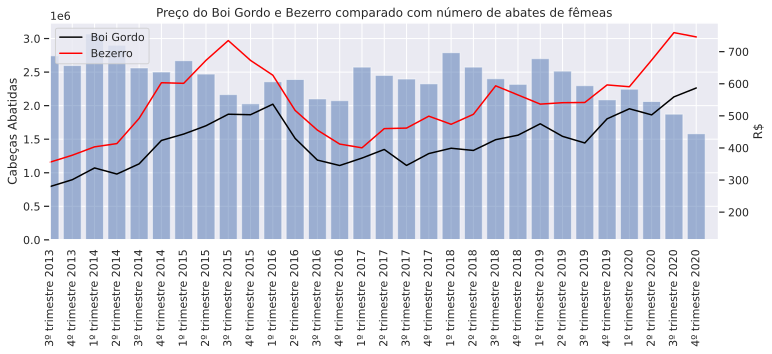

In [29]:
#Plot participação das fêmeas
fig, ax1 = plt.subplots( figsize = (12,4))

ax1.bar(participacao_femeas["Trimestre"], df_final["Vacas"], alpha = 0.5)
ax2 = ax1.twinx()
ax2.plot(df_final["Trimestre"], df_final["Live Cattle"]*df_final["Dollar"], color = "black", Label = "Boi Gordo")
ax2.plot(df_final["Trimestre"], df_final["Feeder Cattle"]*df_final["Dollar"], color = "red", Label = "Bezerro")

ax1.set_ylabel("Cabeças Abatidas")
ax2.set_ylabel("R$")
ax2.grid(False)
ax2.legend()
ax1.set_title("Preço do Boi Gordo e Bezerro comparado com número de abates de fêmeas")
ax1.set_xlim(38, 68)
ax1.set_xticklabels(df_final["Trimestre"], rotation = 90)

plt.show()

O gráfico acima apresenta as curvas de preço do Boi Gordo e do Bezerro, respectivamente da cor preto e vermelho, nessa é possível notar as duas apresentam similaridade, além disso, é possível ver que a quantidade de abates das fêmeas controlas o preço do Boi Gordo e do Bezerro, mostrando que na baixa dos preços existe em relação ao maior número de abates de fêmeas sendo inversamente proporcionais. Muito disso se dar pelo ciclo do crescimento do gado, onde a gestação é de 9 meses com mais 7 meses de desmame reduzindo a oferta de bezerros, note que com o preço do bezerro e do boi gordo subindo o produtor mante mais as suas fêmeas gerando mais bezerro o que gera novamente uma queda no preço e posteriormente maior abate de fêmeas que vai diminuir o número de bezerro gerando o ciclo novamente.

## Tendências

In [30]:
#Criar dataset de preço do bezerro
preco_bezerro = pd.DataFrame()
preco_bezerro["Preço Bezerro"] = dados["Feeder Cattle"]*dados["Dollar"]
preco_bezerro["Date"] = dados["Date"]
preco_bezerro = preco_bezerro.dropna()
preco_bezerro = preco_bezerro.groupby(pd.Grouper(key='Date', freq='Y')).min()

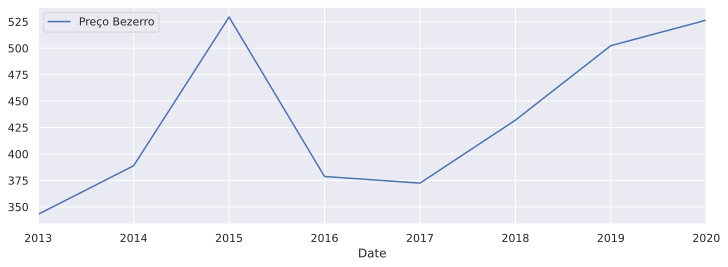

In [35]:
preco_bezerro_seasonal = seasonal_decompose(preco_bezerro)
preco_bezerro_seasonal.trend.plot(figsize = (12,4));

Analisando a tendência do prelo do bezerro é possível notar que essa está em uma fase de aumento de preço desde o ano de 2017.

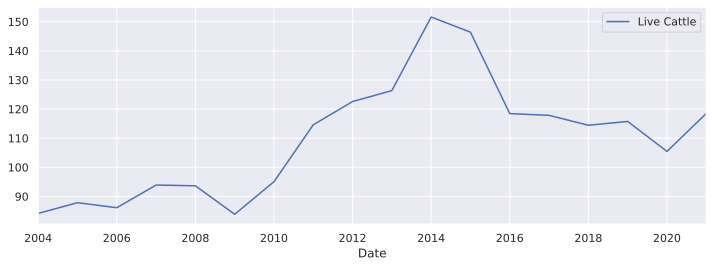

In [36]:
#Tendência do Boi Gordo
boi_gordo_seasonal = seasonal_decompose(boi_gordo_ano)
boi_gordo_seasonal.trend.plot(figsize = (12,4));

No entanto, analisando a tendência anual do preço do boi gordo está em alta também.

## Conclusão

Com base nas análises aqui realizadas é possível concluir que a tendência para o ano de 2021 é o, o preço do bezerro suba e o preço do boi gordo aumente, todavia no ponto de vista mensal existe uma tendência de conduzir as suas baixas de preço destes para o mês de setembro.
Outro ponto notável é o número de abates de fêmeas que tende a baixa, isso pode ser um ponto de alerta para os preços, devido às chances que estes possuem de cair novamente.